In [1]:
import scipy
import utils.preprocess as preprocess
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import solvers.pdas as pdas
import solvers.ipm as ipm
from timeit import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prepare Data

In [2]:
# Load Data
stim = scipy.io.loadmat("./data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("./data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [3]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [4]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

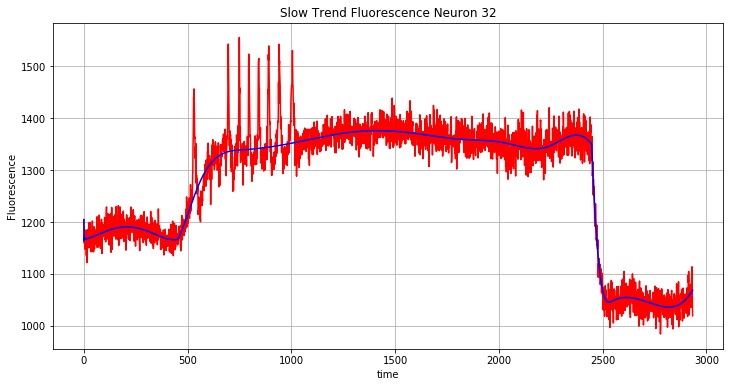

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

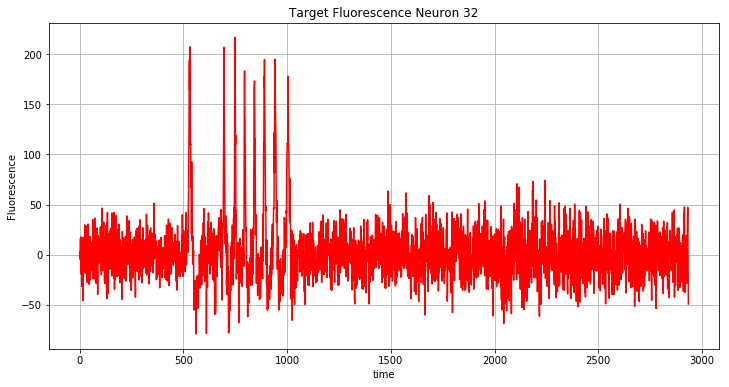

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal, 'r')
#ax.plot(np.arange(T), trend_filtered, 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Test Combined Implementation

In [7]:
idx = np.random.randint(0, N)
y = signals[idx,:].copy()

In [8]:
x_hat, z_hat, iter_ = pdas.solve(y, 500, 1000, 1)

In [9]:
x_hat, z_hat, iter_ = pdas.warm_start(y, 500, z_hat, 1000, 1)

In [10]:
x_hat_full, z_hat, iter_ = ipm.solve(y, 500, False, 1e-4, 200, 1)

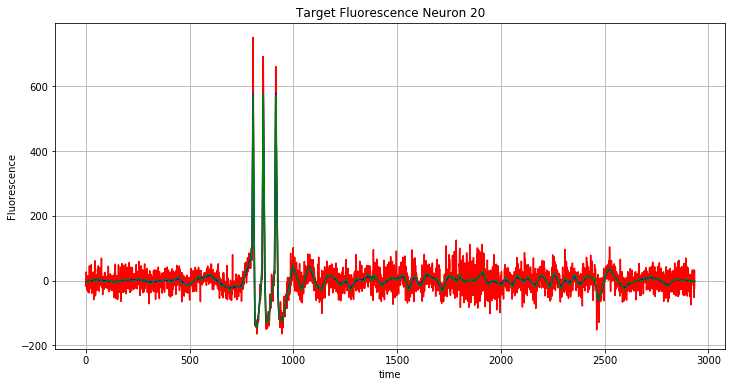

In [11]:
x_hat, z_hat, iter_ = ipm.solve(y, 500, False, 1e6, 200, 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), y, 'r')
ax.plot(np.arange(T), np.array(x_hat_full), 'b')
ax.plot(np.arange(T), np.array(x_hat), 'g')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [12]:
def time_ipm():
    x_hat, z_hat, iter_ = ipm.solve(y, 500, False, 1e-4, 200, 1)
def time_pdas():
    x_hat, z_hat, iter_ = pdas.solve(y, 500, 1000, 1)

In [13]:
timeit(time_ipm, number=10)/10

0.010208933399985654

In [14]:
timeit(time_pdas, number=10)/10

0.015014860199994474

In [15]:
x_hat, z_hat, iter_ = ipm.solve(y, 500, False, 1e2, 200, 1)
x_hat_ipm = np.array(x_hat)
z_hat_ipm = -1 * np.array(z_hat) / 500

In [16]:
idx = np.abs(np.abs(z_hat_ipm) - 1) < 1e-2

In [17]:
z_hat_ipm[idx] = np.sign(z_hat_ipm[idx])

In [18]:
x_hat, _, iter_ = pdas.warm_start(y, 500, z_hat_ipm, 1000, 1)

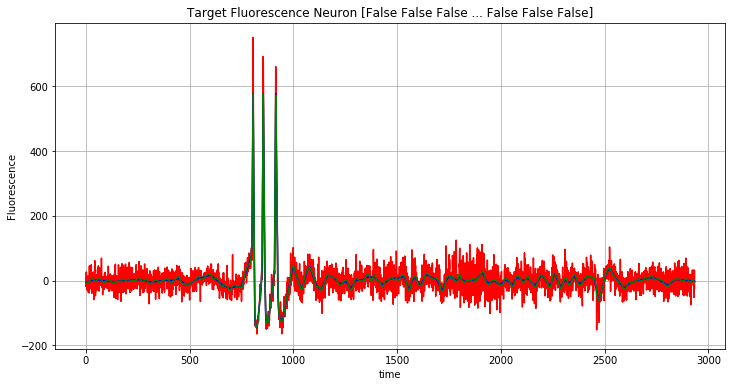

In [19]:
x_hat, z_hat, iter_ = ipm.solve(y, 500, False, 1e6, 200, 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), y, 'r')
ax.plot(np.arange(T), np.array(x_hat_full), 'b')
ax.plot(np.arange(T), np.array(x_hat), 'g')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Warm Start Comparison

In [20]:
idx = np.random.randint(0, N)
signal = signals[idx,:]

In [21]:
ipm_times = np.zeros(30)
pdas_times = np.zeros(30)
sizeData = np.arange(1,31) * T
lam = 500
for ndx in np.arange(1,31):
    target = np.tile(signal, ndx)
    def time_ipm():
        _, _, _ = ipm.solve(target, lam, False, 1e-4, 200, 0)
    def time_pdas():
        _, _, _ = pdas.solve(target, lam, 1000, 1)
    ipm_times[ndx-1] += timeit(time_ipm, number=3)/3
    pdas_times[ndx-1] += timeit(time_pdas, number=3)/3

In [22]:
ipm_tol_times = np.zeros(30)
pdas_ws_times = np.zeros(30)
sizeData = np.arange(1,31) * T
lam = 500
for ndx in np.arange(1,31):
    target = np.tile(signal, ndx)
    def time_ipm():
        _, _, _ = ipm.solve(target, lam, False, 1e2*ndx, 200, 0)
    _, warm_start, _ = pdas.solve(target, lam*1.1, 1000, 1)
    def time_pdas():
        _, _, _ = pdas.warm_start(target, lam, warm_start, 1000, 1)
    ipm_tol_times[ndx-1] += timeit(time_ipm, number=3)/3
    pdas_ws_times[ndx-1] += timeit(time_pdas, number=1)/1

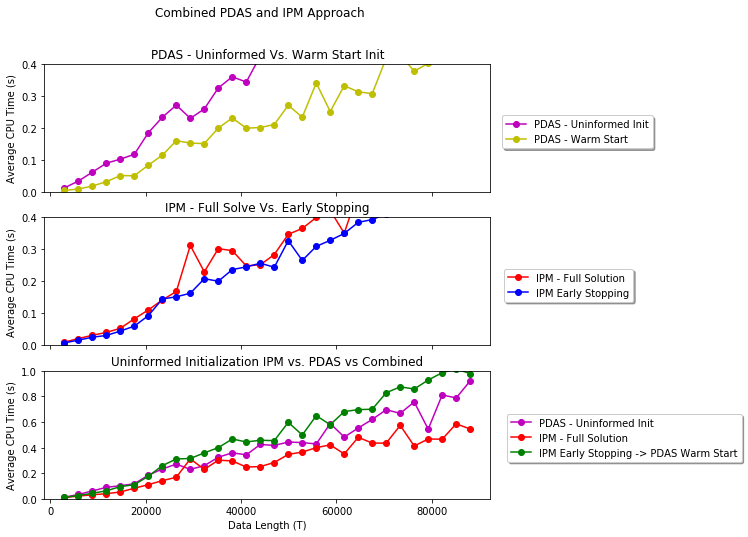

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,8), sharex=False)

ax = axs[0]
ax.plot(sizeData, pdas_times, marker='o', c='m')
ax.plot(sizeData, pdas_ws_times, marker='o', c='y')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('PDAS - Uninformed Vs. Warm Start Init')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['PDAS - Uninformed Init',
           'PDAS - Warm Start'], 
          loc='lower center', 
          bbox_to_anchor=(1.195, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[1]
ax.plot(sizeData, ipm_times, marker='o', c='r')
ax.plot(sizeData, ipm_tol_times, marker='o', c='b')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('IPM - Full Solve Vs. Early Stopping')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['IPM - Full Solution',
           'IPM Early Stopping'], 
          loc='lower center', 
          bbox_to_anchor=(1.175, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[2]
ax.plot(sizeData, pdas_times, marker='o', c='m')
ax.plot(sizeData, ipm_times, marker='o', c='r')
ax.plot(sizeData, ipm_tol_times + pdas_ws_times, marker='o', c='g')
ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Uninformed Initialization IPM vs. PDAS vs Combined')
ax.locator_params(nbins=6)

fig.suptitle('Combined PDAS and IPM Approach')
ax.legend(['PDAS - Uninformed Init',
           'IPM - Full Solution',
           'IPM Early Stopping -> PDAS Warm Start'], 
          loc='lower center', 
          bbox_to_anchor=(1.3, .25),
          ncol=1,
          fancybox=True,
          shadow=True)
#fig.tight_layout()
plt.show()

In [24]:
def time_pdas_long():
    _, _, _ = pdas.solve(np.tile(signal, 5000), 500, 1000, 1)

In [25]:
timeit(time_pdas_long, number=1)

209.382356996

In [26]:
def time_ipm_long():
    _,_,_ = ipm.solve(np.tile(signal, 5000), 500, False, 1e-4, 200, 1)

In [27]:
timeit(time_ipm_long, number=1)

78.52943128600009

# Constrained Problem

In [28]:
import utils.noise
import numpy.random

In [29]:
noise_factor = 3
idx = np.random.randint(0, N)
raw = signals[idx,:]
raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(signal)) + raw
noise_std = utils.noise.estimate_noise([signal], summarize="mean")[0]
delta = (noise_std ** 2)

In [30]:
#r = .0000125
#x_hat, z_hat = ipm.solve(signal.copy(), r, True, 1e-4, 200, 1)
#lam = 3 * noise_std
#var_signal = np.mean(np.power(signal - np.median(signal),2))
var_signal = np.mean(np.power(signal,2))
#scale =  noise_std**2 / np.sqrt(var_signal - delta)
scale =  noise_std**2 / np.sqrt(np.var(signal) - delta)
lam = 3 * scale
x_hat, z_hat, iter_ = ipm.solve(signal.copy(), lam, False, 1e-4, 200, 1)

In [31]:
np.mean(np.power(signal - x_hat, 2))/delta

0.9416997837526897

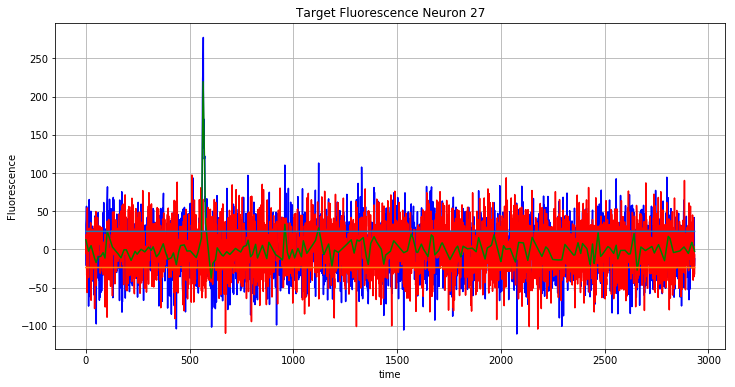

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal, 'b')
ax.plot(np.arange(T), numpy.random.randn(len(signal))*noise_std, 'r')
ax.plot(np.arange(T), np.array(x_hat), 'g')
#ax.plot(np.arange(T), noise_std * 3 * np.ones(len(signal)))
ax.plot(np.arange(T), np.median(np.abs(x_hat - np.median(x_hat))) * 5 * np.ones(len(signal)))
ax.plot(np.arange(T), -1*np.median(np.abs(x_hat - np.median(x_hat))) * 5 * np.ones(len(signal)))
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [33]:
target = signal.copy()
lams = np.logspace(np.log(3),np.log(20),25, base=np.e) * scale
grid = np.log(1 + (lams))
mses = np.zeros(len(lams))
x_hat, z_hat, iter_ = ipm.solve(target, lams[0], False, 1e-4, 200, 1)
mses[0] = np.mean(np.power(signal - x_hat, 2))
for ldx, lam in enumerate(lams[1:]):
    x_hat, z_hat, iter_ = pdas.warm_start(target, lam, z_hat, 1000, 1)
    mses[ldx + 1] = np.mean(np.power(signal - x_hat, 2))

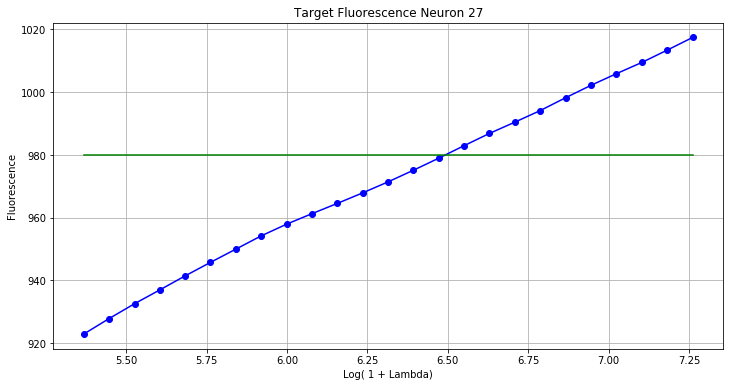

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(lams/scale, mses, 'b')
#ax.plot(lams/scale, np.ones(len(lams))*delta, 'g')
ax.plot(grid, mses, 'b', marker='o')
ax.plot(grid, np.ones(len(lams))*delta, 'g')
ax.set(xlabel='Log( 1 + Lambda)', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [35]:
np.log(1 + lams[-1]) - np.log(1+lams[0])

1.8931484622261445

In [36]:
grid[-1] - grid[0]

1.8931484622261445

In [37]:
int_width = np.log(20 + (1/scale))- np.log(3 + (1/scale))

In [38]:
tau = int_width / 25

In [39]:
tau

0.0757259384890458

In [40]:
lams[10] - lams[9]

35.76195583768015

In [41]:
idx = 9
lams_plus = np.exp(np.log(lams[idx] + 1) - tau) - 1
lams_plus

402.9896871928903

In [42]:
lams_plus

402.9896871928903

In [43]:
lams[idx - 1]

401.72637568576397

In [44]:
target = signal.copy()
_, warm_start, iter_ = pdas.solve(target, lams[0], 500, 1)
def test_ws():
    _, z_hat, iter_ = pdas.warm_start(target, lams[0], warm_start, 1000, 1)
    for lam in lams[1:]:
        _, z_hat, iter_ = pdas.warm_start(target, lam, z_hat, 1000, 1)

In [45]:
timeit(test_ws, number=1)/1

0.046074551999936375

In [46]:
target = signal.copy()
_, warm_start, iter_ = pdas.solve(target, lams[-1], 500, 1)
def test_ws():
    _, z_hat, iter_ = pdas.warm_start(target, lams[-1], warm_start, 1000, 1)
    for lam in lams[-2::-1]:
        _, z_hat, iter_ = pdas.warm_start(target, lam, z_hat, 1000, 1)

In [47]:
timeit(test_ws, number=1)/1

0.10505760199998804

In [48]:
def test_naive():
    for lam in lams[1:]:
        _, z_init, iter_ = ipm.solve(target, lam, False, 1e-4, 200, 1)

In [49]:
timeit(test_naive, number=10)/10

0.21816597299998647

In [50]:
np.min(np.abs(mses-delta))/delta

0.001136553526997525

# Smart Searches

In [51]:
noise_factor = 5
idx = np.random.randint(0, N)
raw = signals[idx,:]
raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(signal)) + raw
noise_std = utils.noise.estimate_noise([signal], summarize="mean")[0]
delta = (noise_std ** 2)

In [52]:
var_signal = np.mean(np.power(signal,2))
scale =  noise_std**2 / np.sqrt(var_signal - delta)
lam = 3 * scale
x_hat, z_hat, iter_ = ipm.solve(signal.copy(), lam, False, 1e-4, 200, 1)

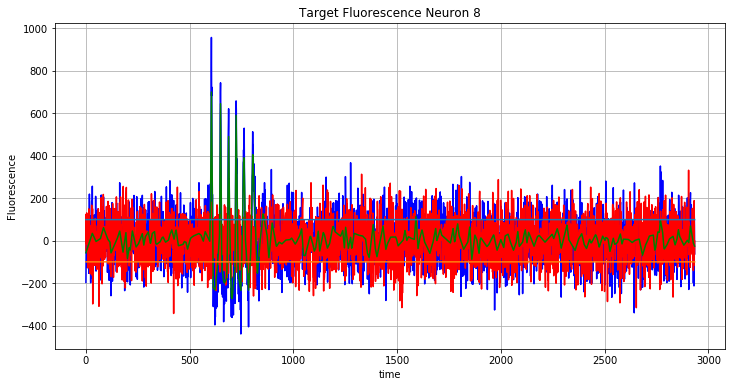

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal, 'b')
ax.plot(np.arange(T), numpy.random.randn(len(signal))*noise_std, 'r')
ax.plot(np.arange(T), np.array(x_hat), 'g')
ax.plot(np.arange(T), np.median(np.abs(x_hat - np.median(x_hat))) * 5 * np.ones(len(signal)))
ax.plot(np.arange(T), -1*np.median(np.abs(x_hat - np.median(x_hat))) * 5 * np.ones(len(signal)))
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [54]:
def solve_constrained_a(y, step_heuristic=60, maxiter=2000, verbose=0):
    # estimate noise levels and scale
    noise_std = utils.noise.estimate_noise([y], summarize="mean")[0]
    delta = noise_std ** 2  # constraint to satisfy
    scale = delta / np.sqrt(np.mean(np.power(y, 2) - delta)) # assuming centered
    
    # Compute first search point and step size
    int_min = np.log(3*scale + 1)
    int_width = np.log(20+(1/scale)) - np.log(3+(1/scale))
    lam = np.exp(int_width / 2 + int_min) - 1
    tau_int =  int_width / step_heuristic
    
    # Compute initial solution
    x_hat, z_hat, first_iters = pdas.solve(y, lam, maxiter, verbose) # TODO record num iters for comparison
    extra_iters = 0
    mse = np.mean(np.power(y - x_hat,2))
    first_tol = np.abs(delta - mse)/delta
    direction = np.sign(delta - mse)
    n_lam = 1
    
    # Compare iterating until we step across delta
    while (direction * np.sign(delta - mse) > 0):
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        x_hat, z_hat, iters = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        extra_iters += iters
        n_lam += 1
    
    if direction != 0:
        # Interpolate for final fit
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        x_hat, z_hat, iters = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        extra_iters += iters
        n_lam += 1
        tol = np.abs(delta - mse)/delta
    else:
        tol = np.abs(delta - mse)/delta
    
    # return final computed solution
    return x_hat, z_hat, lam, first_iters, extra_iters, n_lam, tol, first_tol

In [55]:
x_hat, z_hat, lam, first_iter, extra_iter, n_lam, tol, ftol = solve_constrained_a(signal, step_heuristic=20)

In [56]:
search_points = np.arange(10,200,1)
n_sols=np.zeros(len(search_points))
first_iters=np.zeros(len(search_points))
extra_iters=np.zeros(len(search_points))
tols=np.zeros(len(search_points))
for ndx, num_points in enumerate(search_points):
    lams = np.logspace(np.log(3),np.log(20), num_points, base=np.e) * scale
    _, _, _, first_iter, extra_iter, n_lam, tol, _ = solve_constrained_a(signal, step_heuristic=num_points)
    first_iters[ndx] = first_iter
    n_sols[ndx] = n_lam
    extra_iters[ndx] = extra_iter
    tols[ndx] = tol

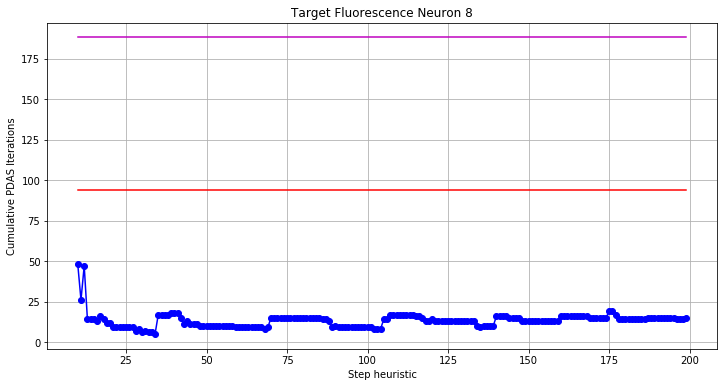

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(lams/scale, mses, 'b')
#ax.plot(lams/scale, np.ones(len(lams))*delta, 'g')
ax.plot(search_points, extra_iters, 'b', marker='o')
#ax.plot(search_points, n_sols, 'g', marker='o')
#ax.plot(search_points, tols*1e9, 'y', marker='o')
ax.plot(search_points, np.ones(len(search_points))*first_iters, 'r')
ax.plot(search_points, np.ones(len(search_points))*2*first_iters, 'm')
ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

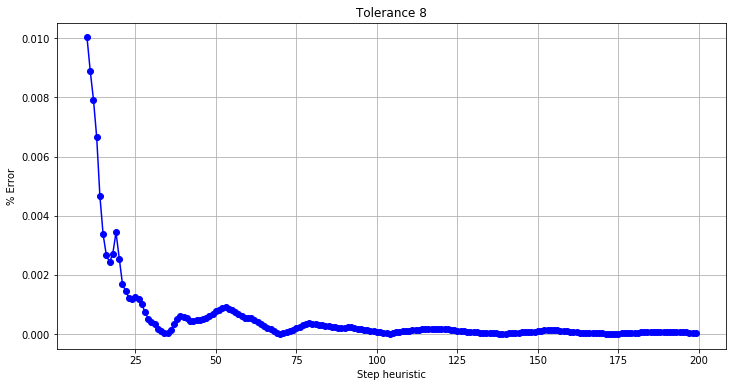

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(lams/scale, mses, 'b')
#ax.plot(lams/scale, np.ones(len(lams))*delta, 'g')
ax.plot(search_points, tols*100, 'b', marker='o')
#ax.plot(search_points, n_sols, 'g', marker='o')
#ax.plot(search_points, tols*1e9, 'y', marker='o')
#ax.plot(search_points, np.ones(len(search_points))*first_iters, 'r')
#ax.plot(search_points, np.ones(len(search_points))*2*first_iters, 'm')
ax.set(xlabel='Step heuristic', ylabel='% Error',
       title='Tolerance {}'.format(idx))
ax.grid()

plt.show()

In [59]:
search_points = np.arange(10,150,2)
noise_factors = np.arange(1,8)
n_sols_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
first_iters_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
extra_iters_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
tols_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
ftols_a=np.zeros([len(signals), len(noise_factors), len(search_points)])
for sdx, raw in enumerate(signals):
    for ndx, noise_factor in enumerate(noise_factors):
        raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
        signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(signal)) + raw
        for pdx, num_points in enumerate(search_points):
            _, _, _, first_iter, extra_iter, n_lam, tol, ftol = solve_constrained_a(signal, step_heuristic=num_points)
            first_iters_a[sdx, ndx, pdx] = first_iter
            n_sols_a[sdx, ndx, pdx] = n_lam
            extra_iters_a[sdx, ndx, pdx]= extra_iter
            tols_a[sdx, ndx, pdx] = tol
            ftols_a[sdx, ndx, pdx] = ftol

In [60]:
#fig, ax = plt.subplots(5,1,figsize=(12, 30))
#for ndx, noise_factor in enumerate(noise_factors):
    #for sdx, signal in enumerate(signals):
        #ax[ndx].plot(search_points, ftols[sdx,ndx,:]*100)
        #ax[ndx].plot(search_points, tols[sdx,ndx,:]*100)
        #ax[ndx].plot(search_points, np.mean(extra_iters/first_iters, axis=0)[ndx,:])
        #ax[sdx].plot(search_points, n_sols[sdx, ndx,:])
        #ax[sdx].plot(search_points, extra_iters[sdx, ndx,:])
#ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
#       title='Target Fluorescence Neuron {}'.format(idx))
#ax.grid()
#plt.show()

In [61]:
def solve_constrained_b(y, step_heuristic=60, maxiter=2000, verbose=0):
    # estimate noise levels and scale
    noise_std = utils.noise.estimate_noise([y], summarize="mean")[0]
    delta = noise_std ** 2  # constraint to satisfy
    scale = delta / np.sqrt(np.mean(np.power(y, 2) - delta)) # assuming centered
    
    # Compute first search point and step size
    int_min = np.log(3*scale + 1)
    int_width = np.log(20+(1/scale)) - np.log(3+(1/scale))
    lam = np.exp(int_width / 2 + int_min) - 1
    tau_int =  int_width / step_heuristic
    
    # Compute initial solution
    x_hat, z_hat, first_iters = pdas.solve(y, lam, maxiter, verbose)
    extra_iters = 0
    mse = np.mean(np.power(y - x_hat,2))
    first_tol = np.abs(delta - mse)/delta
    direction = np.sign(delta - mse)
    n_lam = 1
    
    if direction != 0:
        # Take step to compute slope in transformed space
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        x_hat, z_hat, iters = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        extra_iters += iters
        n_lam += 1
        
        # Interpolate in transformed space for final fit
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        x_hat, z_hat, iters = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        extra_iters += iters
        n_lam += 1
        tol = np.abs(delta - mse)/delta
    else:
        tol = first_tol
    
    # return final computed solution
    return x_hat, z_hat, lam, first_iters, extra_iters, n_lam, tol, first_tol

In [62]:
x_hat, z_hat, lam, first_iter, extra_iter, n_lam, tol, ftol = solve_constrained_b(signal.copy(), step_heuristic=20)

In [63]:
search_points = np.arange(10,200,1)
n_sols=np.zeros(len(search_points))
first_iters=np.zeros(len(search_points))
extra_iters=np.zeros(len(search_points))
tols=np.zeros(len(search_points))
for ndx, num_points in enumerate(search_points):
    lams = np.logspace(np.log(3),np.log(20), num_points, base=np.e) * scale
    _, _, _, first_iter, extra_iter, n_lam, tol, _ = solve_constrained_b(signal, step_heuristic=num_points)
    first_iters[ndx] = first_iter
    n_sols[ndx] = n_lam
    extra_iters[ndx] = extra_iter
    tols[ndx] = tol

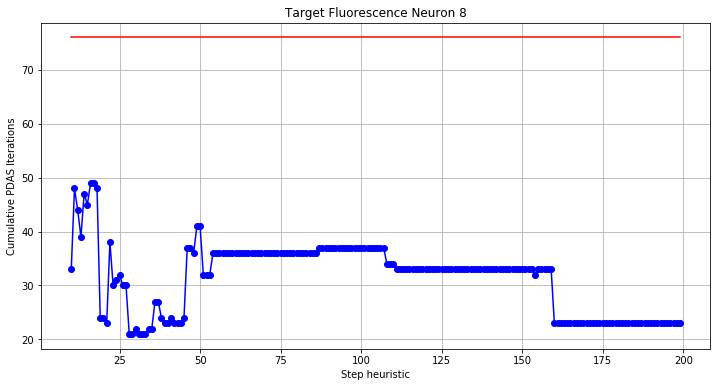

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(lams/scale, mses, 'b')
#ax.plot(lams/scale, np.ones(len(lams))*delta, 'g')
ax.plot(search_points, extra_iters, 'b', marker='o')
#ax.plot(search_points, n_sols, 'g', marker='o')
#ax.plot(search_points, tols*1e9, 'y', marker='o')
ax.plot(search_points, np.ones(len(search_points))*first_iters, 'r')
#ax.plot(search_points, np.ones(len(search_points))*2*first_iters, 'm')
ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

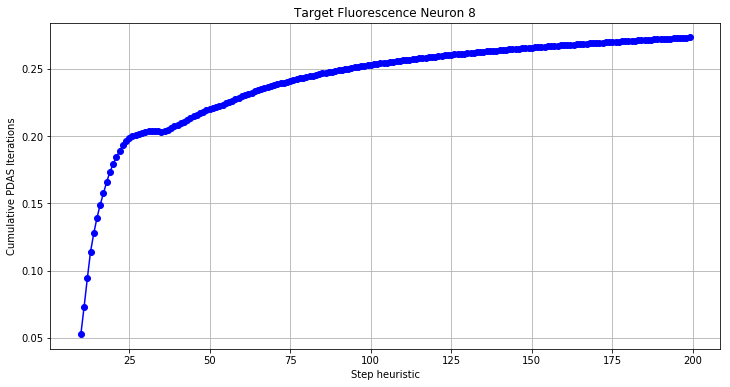

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(lams/scale, mses, 'b')
#ax.plot(lams/scale, np.ones(len(lams))*delta, 'g')
ax.plot(search_points, tols*100, 'b', marker='o')
#ax.plot(search_points, n_sols, 'g', marker='o')
#ax.plot(search_points, tols*1e9, 'y', marker='o')
#ax.plot(search_points, np.ones(len(search_points))*first_iters, 'r')
#ax.plot(search_points, np.ones(len(search_points))*2*first_iters, 'm')
ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [66]:
search_points = np.arange(10,150,2)
noise_factors = np.arange(1,8)
n_sols_b=np.zeros([len(signals), len(noise_factors), len(search_points)])
first_iters_b=np.zeros([len(signals), len(noise_factors), len(search_points)])
extra_iters_b=np.zeros([len(signals), len(noise_factors), len(search_points)])
tols_b=np.zeros([len(signals), len(noise_factors), len(search_points)])
ftols_b=np.zeros([len(signals), len(noise_factors), len(search_points)])
for sdx, raw in enumerate(signals):
    for ndx, noise_factor in enumerate(noise_factors):
        raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
        signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(signal)) + raw
        for pdx, num_points in enumerate(search_points):
            _, _, _, first_iter, extra_iter, n_lam, tol, ftol = solve_constrained_b(signal, step_heuristic=num_points)
            first_iters_b[sdx, ndx, pdx] = first_iter
            n_sols_b[sdx, ndx, pdx] = n_lam
            extra_iters_b[sdx, ndx, pdx]= extra_iter
            tols_b[sdx, ndx, pdx] = tol
            ftols_b[sdx, ndx, pdx] = ftol

In [67]:
def solve_constrained_c(y, step_heuristic=60, maxiter=2000, verbose=0):
    # estimate noise levels and scale
    noise_std = utils.noise.estimate_noise([y], summarize="mean")[0]
    delta = noise_std ** 2  # constraint to satisfy
    scale = delta / np.sqrt(np.mean(np.power(y, 2) - delta)) # assuming centered
    
    # Compute first search point and step size
    int_min = np.log(3*scale + 1)
    int_width = np.log(20+(1/scale)) - np.log(3+(1/scale))
    lam = np.exp(int_width / 2 + int_min) - 1
    tau_int =  int_width / step_heuristic
    
    # Compute initial solution
    x_hat, z_hat, first_iters = pdas.solve(y, lam, maxiter, verbose)
    extra_iters = 0
    mse = np.mean(np.power(y - x_hat,2))
    first_tol = np.abs(delta - mse)/delta
    direction = np.sign(delta - mse)
    n_lam = 1
    
    if direction != 0:
        # Take step to compute slope in transformed space
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        x_hat, z_hat, iters = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        extra_iters += iters
        n_lam += 1
        
        # Interpolate in transformed space for final fit
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        x_hat, z_hat, iters = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        extra_iters += iters
        n_lam += 1
        direction = np.sign(delta - mse)

   # Compare iterating until we step across delta
    while (direction * np.sign(delta - mse) > 0):
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        x_hat, z_hat, iters = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        extra_iters += iters
        n_lam += 1
    
    if direction != 0:
        # Interpolate for final fit
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        x_hat, z_hat, iters = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        extra_iters += iters
        n_lam += 1
        tol = np.abs(delta - mse)/delta
    else:
        tol = np.abs(delta - mse)/delta
    
    # return final computed solution
    return x_hat, z_hat, lam, first_iters, extra_iters, n_lam, tol, first_tol

In [68]:
x_hat, z_hat, lam, first_iter, extra_iter, n_lam, tol, ftol = solve_constrained_c(signal.copy(), step_heuristic=20)

In [69]:
search_points = np.arange(10,200,1)
n_sols=np.zeros(len(search_points))
first_iters=np.zeros(len(search_points))
extra_iters=np.zeros(len(search_points))
tols=np.zeros(len(search_points))
for ndx, num_points in enumerate(search_points):
    lams = np.logspace(np.log(3),np.log(20), num_points, base=np.e) * scale
    _, _, _, first_iter, extra_iter, n_lam, tol, _ = solve_constrained_c(signal, step_heuristic=num_points)
    first_iters[ndx] = first_iter
    n_sols[ndx] = n_lam
    extra_iters[ndx] = extra_iter
    tols[ndx] = tol

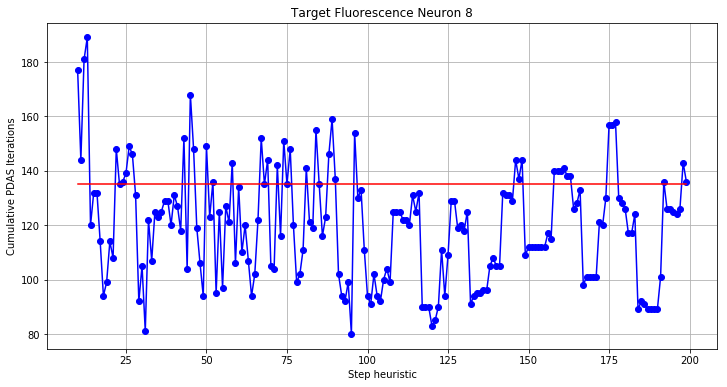

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(lams/scale, mses, 'b')
#ax.plot(lams/scale, np.ones(len(lams))*delta, 'g')
ax.plot(search_points, extra_iters, 'b', marker='o')
#ax.plot(search_points, n_sols, 'g', marker='o')
#ax.plot(search_points, tols*1e9, 'y', marker='o')
ax.plot(search_points, np.ones(len(search_points))*first_iters, 'r')
#ax.plot(search_points, np.ones(len(search_points))*2*first_iters, 'm')
ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

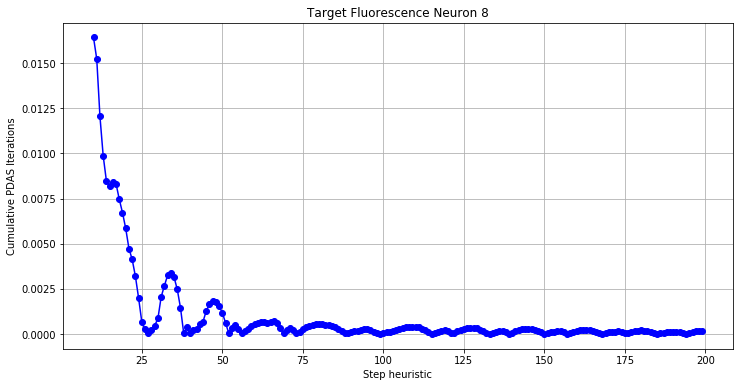

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(lams/scale, mses, 'b')
#ax.plot(lams/scale, np.ones(len(lams))*delta, 'g')
ax.plot(search_points, tols*100, 'b', marker='o')
#ax.plot(search_points, n_sols, 'g', marker='o')
#ax.plot(search_points, tols*1e9, 'y', marker='o')
#ax.plot(search_points, np.ones(len(search_points))*first_iters, 'r')
#ax.plot(search_points, np.ones(len(search_points))*2*first_iters, 'm')
ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [72]:
search_points = np.arange(10,150,2)
noise_factors = np.arange(1,8)
n_sols_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
first_iters_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
extra_iters_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
tols_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
ftols_c=np.zeros([len(signals), len(noise_factors), len(search_points)])
for sdx, raw in enumerate(signals):
    for ndx, noise_factor in enumerate(noise_factors):
        raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
        signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(signal)) + raw
        for pdx, num_points in enumerate(search_points):
            _, _, _, first_iter, extra_iter, n_lam, tol, ftol = solve_constrained_c(signal, step_heuristic=num_points)
            first_iters_c[sdx, ndx, pdx] = first_iter
            n_sols_c[sdx, ndx, pdx] = n_lam
            extra_iters_c[sdx, ndx, pdx]= extra_iter
            tols_c[sdx, ndx, pdx] = tol
            ftols_c[sdx, ndx, pdx] = ftol

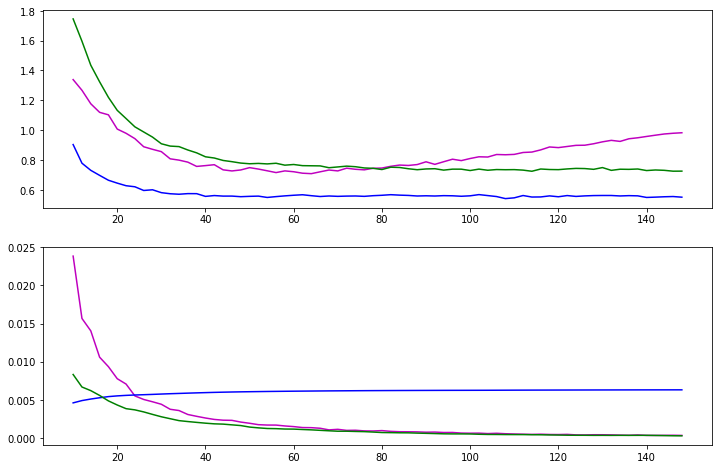

In [73]:
fig, ax = plt.subplots(2,1,figsize=(12, 8))
#for ndx, noise_factor in enumerate(noise_factors):
    #for sdx, signal in enumerate(signals):
        #ax[ndx].plot(search_points, ftols_c[sdx,ndx, :]*100)
        #ax[ndx].plot(search_points, tols_c[sdx,ndx, :]*100)
ax[0].plot(search_points, np.mean(np.mean(extra_iters_a/first_iters_a, axis=0), axis=0), 'm')
ax[0].plot(search_points, np.mean(np.mean(extra_iters_b/first_iters_b, axis=0), axis=0), 'b')
ax[0].plot(search_points, np.mean(np.mean(extra_iters_c/first_iters_c, axis=0), axis=0), 'g')
ax[1].plot(search_points, np.mean(np.mean(tols_a*100, axis=0), axis=0), 'm')
ax[1].plot(search_points, np.mean(np.mean(tols_b, axis=0), axis=0), 'b')
ax[1].plot(search_points, np.mean(np.mean(tols_c*100, axis=0), axis=0), 'g')
        #ax[sdx].plot(search_points, n_sols_c[sdx, ndx, :])
        #ax[sdx].plot(search_points, extra_iters_c[sdx, ndx, :])
#ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
#       title='Target Fluorescence Neuron {}'.format(idx))
#ax.grid()
plt.show()

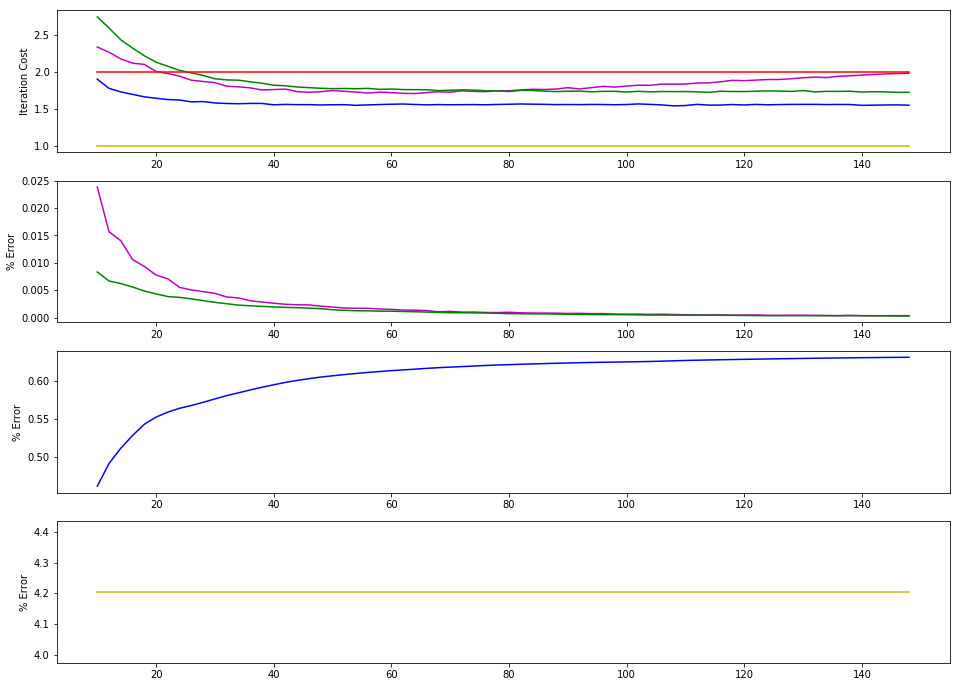

In [98]:
fig, ax = plt.subplots(4,1,figsize=(16, 12))
#for ndx, noise_factor in enumerate(noise_factors):
    #for sdx, signal in enumerate(signals):
        #ax[ndx].plot(search_points, ftols_c[sdx,ndx, :]*100)
        #ax[ndx].plot(search_points, tols_c[sdx,ndx, :]*100)
ax[0].plot(search_points, 1 + np.mean(np.mean(extra_iters_a/first_iters_a, axis=0), axis=0), 'm')
ax[0].plot(search_points, 1 + np.mean(np.mean(extra_iters_b/first_iters_b, axis=0), axis=0), 'b')
ax[0].plot(search_points, 1 + np.mean(np.mean(extra_iters_c/first_iters_c, axis=0), axis=0), 'g')
ax[0].plot(search_points, np.ones(len(search_points)), 'y')
ax[0].plot(search_points, 2*np.ones(len(search_points)), 'r')
ax[1].plot(search_points, np.mean(np.mean(tols_a*100, axis=0), axis=0), 'm')
ax[2].plot(search_points, np.mean(np.mean(tols_b*100, axis=0), axis=0), 'b')
ax[1].plot(search_points, np.mean(np.mean(tols_c*100, axis=0), axis=0), 'g')
ax[3].plot(search_points, np.mean(np.mean(ftols_a*100, axis=0), axis=0), 'y')
ax[0].set(ylabel = 'Iteration Cost')
ax[1].set(ylabel = '% Error')
ax[2].set(ylabel = '% Error')
ax[3].set(ylabel = '% Error')
#ax[3].plot(search_points, np.mean(np.mean(ftols_b*100, axis=0), axis=0), 'b')
#ax[2].plot(search_points, np.mean(np.mean(ftols_c*100, axis=0), axis=0), 'g')
        #ax[sdx].plot(search_points, n_sols_c[sdx, ndx, :])
        #ax[sdx].plot(search_points, extra_iters_c[sdx, ndx, :])
#ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
#       title='Target Fluorescence Neuron {}'.format(idx))
#ax.grid()
plt.show()

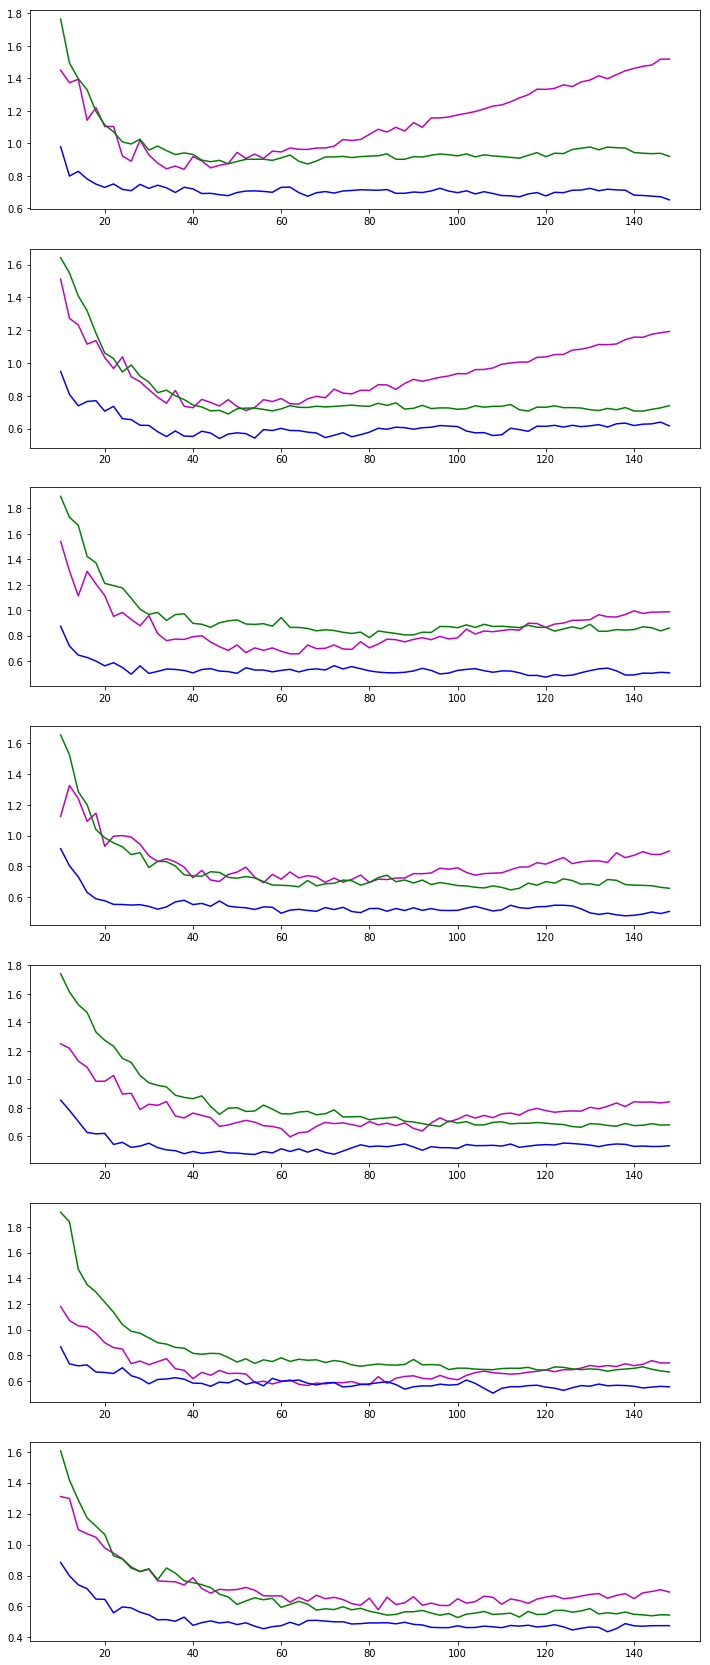

In [74]:
fig, ax = plt.subplots(7,1,figsize=(12, 30))
for ndx, noise_factor in enumerate(noise_factors):
    #for sdx, signal in enumerate(signals):
        #ax[ndx].plot(search_points, ftols_c[sdx,ndx, :]*100)
        #ax[ndx].plot(search_points, tols_c[sdx,ndx, :]*100)
    ax[ndx].plot(search_points, np.mean(extra_iters_a/first_iters_a, axis=0)[ndx,:], 'm')
    ax[ndx].plot(search_points, np.mean(extra_iters_b/first_iters_b, axis=0)[ndx,:], 'b')
    ax[ndx].plot(search_points, np.mean(extra_iters_c/first_iters_c, axis=0)[ndx,:], 'g')
        #ax[sdx].plot(search_points, n_sols_c[sdx, ndx, :])
        #ax[sdx].plot(search_points, extra_iters_c[sdx, ndx, :])
#ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
#       title='Target Fluorescence Neuron {}'.format(idx))
#ax.grid()
plt.show()

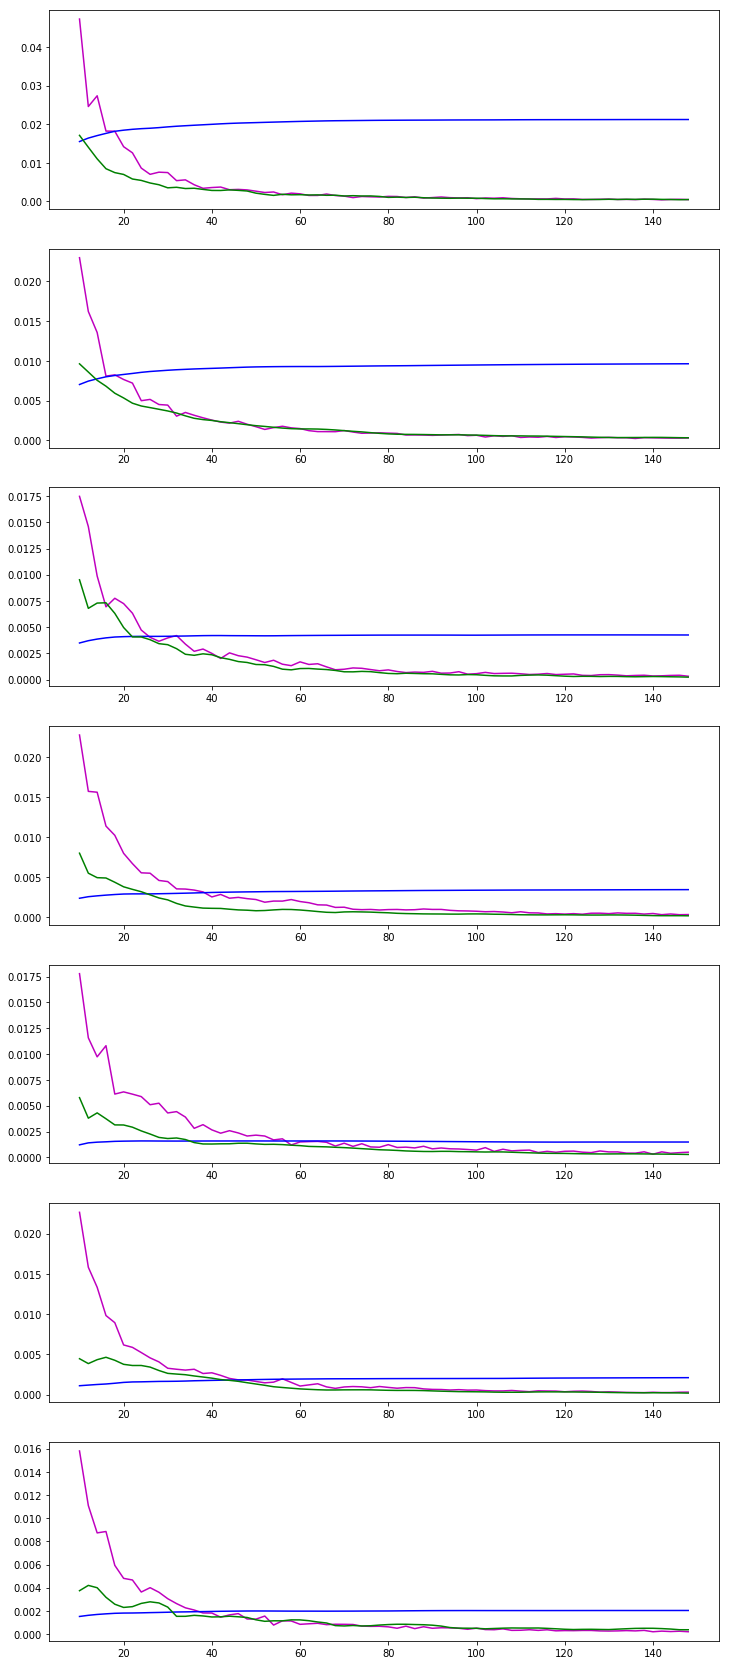

In [75]:
fig, ax = plt.subplots(7,1,figsize=(12, 30))
for ndx, noise_factor in enumerate(noise_factors):
    #for sdx, signal in enumerate(signals):
        #ax[ndx].plot(search_points, ftols_c[sdx,ndx, :]*100)
        #ax[ndx].plot(search_points, tols_c[sdx,ndx, :]*100)
    ax[ndx].plot(search_points, np.mean(tols_a, axis=0)[ndx,:]*100, 'm')
    ax[ndx].plot(search_points, np.mean(tols_b, axis=0)[ndx,:]*1, 'b')
    ax[ndx].plot(search_points, np.mean(tols_c, axis=0)[ndx,:]*100, 'g')
        #ax[sdx].plot(search_points, n_sols_c[sdx, ndx, :])
        #ax[sdx].plot(search_points, extra_iters_c[sdx, ndx, :])
#ax.set(xlabel='Step heuristic', ylabel='Cumulative PDAS Iterations',
#       title='Target Fluorescence Neuron {}'.format(idx))
#ax.grid()
plt.show()

# Search Movies